<b>Cardio Catch Diseases</b>

A Cardio Catch Diseases é uma empresa de diagnóstico 

 # 0.0 IMPORTAÇÕES E FUNÇÕES DE AJUDA


In [16]:
import pandas                                       as pd
import numpy                                        as np
import seaborn                                      as sns
import matplotlib.pyplot                            as plt
import datetime                                     as dt
import xgboost                                      as xgb
import pickle
import random

from scipy                          import stats        as ss
from scikitplot                     import metrics      as mt
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection        import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.ensemble               import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model           import LogisticRegression, RidgeClassifier
from lightgbm                       import LGBMClassifier
from scikitplot.metrics             import plot_confusion_matrix, plot_roc_curve, plot_cumulative_gain
from sklearn.metrics                import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve, cohen_kappa_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics                import plot_confusion_matrix, classification_report
from imblearn.combine               import SMOTETomek
from category_encoders              import MEstimateEncoder, TargetEncoder




In [17]:
mms = MinMaxScaler()
rs = RobustScaler()
le = LabelEncoder()

In [18]:
df_raw = pd.read_csv('data\cardio_train.csv', sep=';')

In [19]:

def df_scores(model_name, y_test, y_pred, normalize=False):  
       
    results = {'accuracy_score': accuracy_score(y_test, y_pred),
             'precision_score': precision_score(y_test, y_pred),
             'recall_score': recall_score(y_test, y_pred),
             'f1_score': f1_score(y_test, y_pred),
             'roc_auc': roc_auc_score(y_test, y_pred),
             'kappa_score': cohen_kappa_score(y_test, y_pred)}
    results = pd.DataFrame(results, index=[model_name])
                 
   
    return results if normalize == False else np.round(results * 100, 3)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 30
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Roney\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0 DESCRIÇÃO DOS DADOS

In [20]:
df1 = df_raw.copy()

## 1.1 Tamanho do DataSet

In [21]:
print(f'Números de linhas: {df1.shape[0]}')
print(f'Números de colunas: {df1.shape[1]}')

Números de linhas: 70000
Números de colunas: 13


## 1.2 Nomes das Colunas

In [22]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.3 Tipos de Dados

In [23]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Check NA

In [24]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5 Estatística Descritiva

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [26]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0 FEATURE ENGENEERING

In [27]:
df2 = df1.copy()

In [28]:
# Criando a variável ano de nascimento.
df2['born_year'] = df2['age'].apply(lambda x: (dt.datetime.today() - dt.timedelta(days=x)).year)

df2['idade'] = df2['age'].apply(lambda x: x/365).astype(int)

# Criando coluna IMC
df2['imc'] = df2.apply(lambda x: x['weight'] / (x['height']/100)**2, axis=1)

# Trocando os valores da variável gender de 1-2 para 0-1
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 2 else 1)

# Criando coluna sobre hipertensão
df2['blood_pressure'] = df2[['ap_hi', 'ap_lo']].apply(lambda x: 'normal' if ((x['ap_lo'] <= 80) & (x['ap_hi'] <= 120 )) else
                                        'elevated' if (x['ap_lo'] <= 80) & (x['ap_hi'] > 120 | x['ap_hi'] <= 129) else
                                        'hypertension stage 1' if ((x['ap_lo'] > 80) | x['ap_lo'] <= 89 ) |  (x['ap_hi'] > 130 | x['ap_hi'] <= 139) else
                                        'hypertension stage 2' if (x['ap_lo'] >= 90) |  (x['ap_hi'] >= 140 )
                                        else 'NONE', axis=1)


In [29]:
df2

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,born_year,idade,imc,blood_pressure
0,0,18393,0,168,62.0,110,80,1,1,0,0,1,0,1972,50,21.967120,normal
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1967,55,34.927679,hypertension stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,1971,51,23.507805,hypertension stage 1
3,3,17623,0,169,82.0,150,100,1,1,0,0,1,1,1974,48,28.710479,hypertension stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1974,47,23.011177,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,0,168,76.0,120,80,1,1,1,0,1,0,1969,52,26.927438,normal
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,1960,61,50.472681,hypertension stage 2
69997,99996,19066,0,183,105.0,180,90,3,1,0,1,0,1,1970,52,31.353579,hypertension stage 2
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,1961,61,27.099251,hypertension stage 1


# 3.0 FILTRAGEM DE DADOS

In [30]:
df3 = df2.copy()

In [31]:
# Removendo inconsistencias na pressão.
for i in range(len(df3)):
    if df3.loc[i, 'ap_hi'] < df3.loc[i, 'ap_lo']:
        df3 = df3.drop(i)

# Removendo inconsistencias na altura.
df3 = df3[df3['height'] >= 140]
df3 = df3[df3['height'] <= 220]

# Removendo inconsistencias na variável peso.
df3 = df3[df3['weight'] >= 43]

# Removendo inconsistencias na pressão.
df3 = df3[df3['ap_lo'] >= 65]
df3 = df3[df3['ap_lo'] <= 150]
df3 = df3[df3['ap_hi'] >= 90]
df3 = df3[df3['ap_hi'] <= 220]


# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [32]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.2 Análise Bivariada

1 - Pessoas com mais idade, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

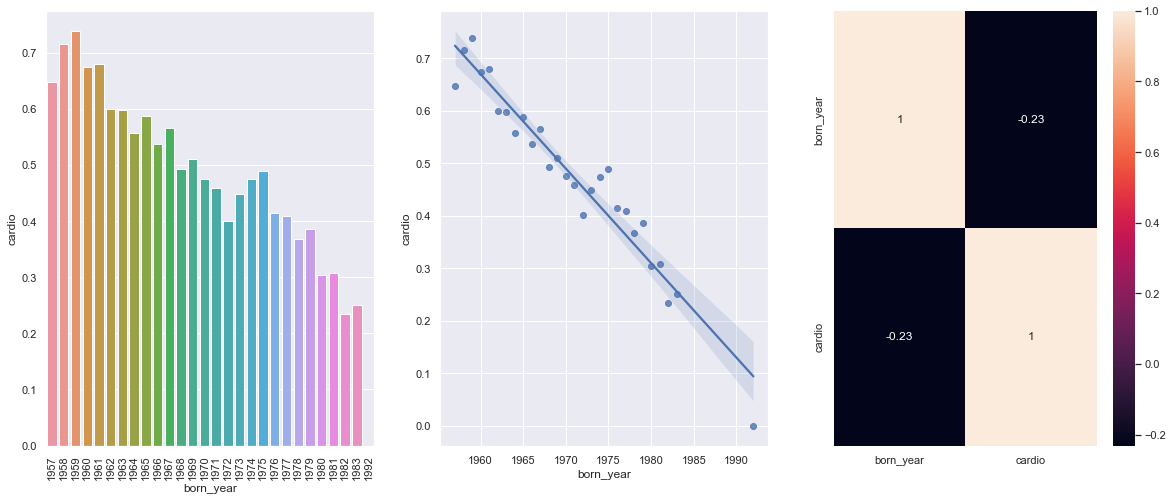

In [33]:
aux = df4[['born_year', 'cardio']].groupby('born_year').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='born_year', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='born_year', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['born_year', 'cardio']].corr(method='pearson'), annot=True)

2 - Homens e Mulheres tem em média chances diferentes de sofrer um ataque cardiaco. (Falso!)

<AxesSubplot:>

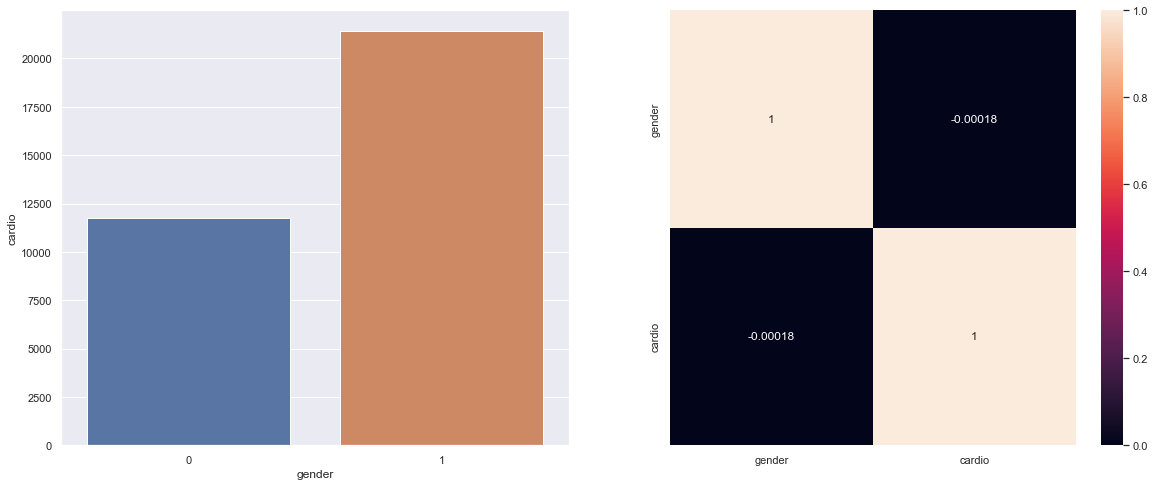

In [34]:
aux = df4[['gender', 'cardio', 'age']].groupby('gender').sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gender', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['gender', 'cardio']].corr(method='pearson'), annot=True)

3 - Altura não aumenta as chances de ataque cardiaco. (Verdadeiro)

<AxesSubplot:>

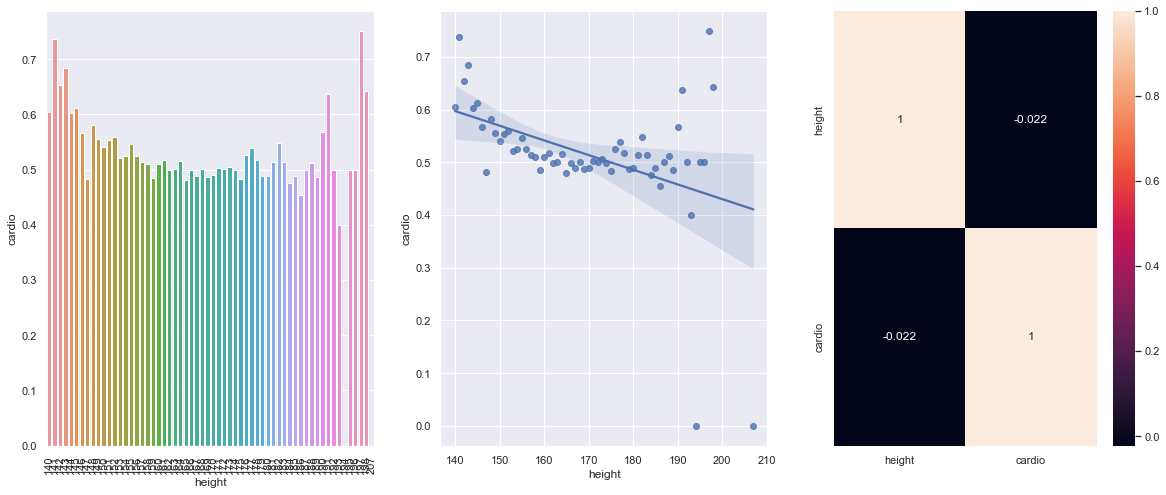

In [35]:
aux = df4[['height', 'cardio']].groupby('height').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='height', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='height', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['height', 'cardio']].corr(method='pearson'), annot=True)

4 - Quando maior o peso da pessoa, maior a chance de ela ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

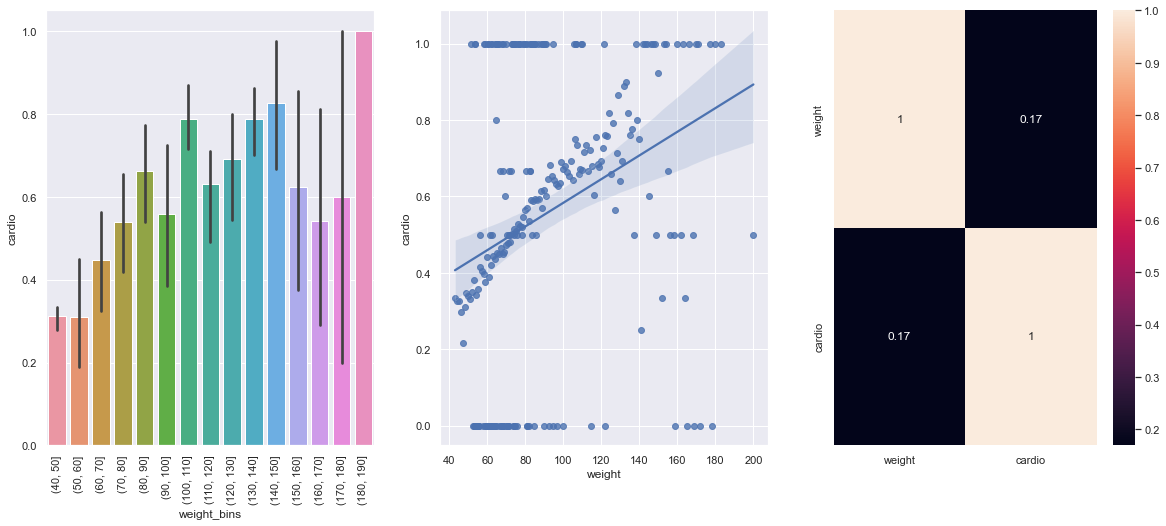

In [36]:
aux = df4[['weight', 'cardio']].groupby('weight').mean().reset_index()


bins = list(np.arange(40,200, 10))

aux['weight_bins'] = pd.cut(aux['weight'], bins=bins)
aux1 = aux[['weight_bins', 'cardio']].groupby('weight_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='weight_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='weight', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['weight', 'cardio']].corr(method='pearson'), annot=True)

5 - Quanto pior o quadro de hypertensão, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

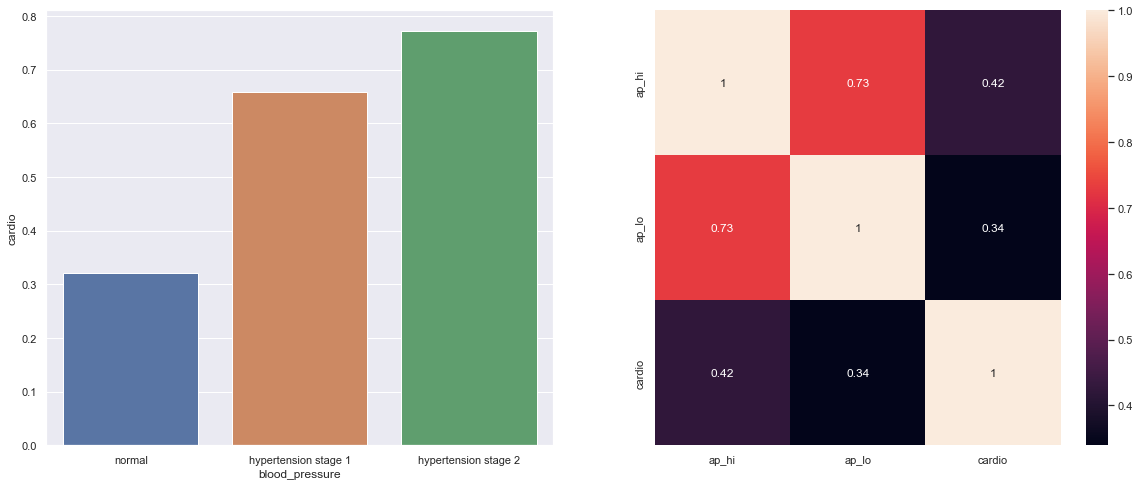

In [37]:
aux = df4[['blood_pressure', 'cardio']].groupby('blood_pressure').mean().reset_index().sort_values('cardio')

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='blood_pressure', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['ap_hi', 'ap_lo', 'cardio']].corr(method='pearson'), annot=True)

6 - Quanto pior o quadro de colesterol, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

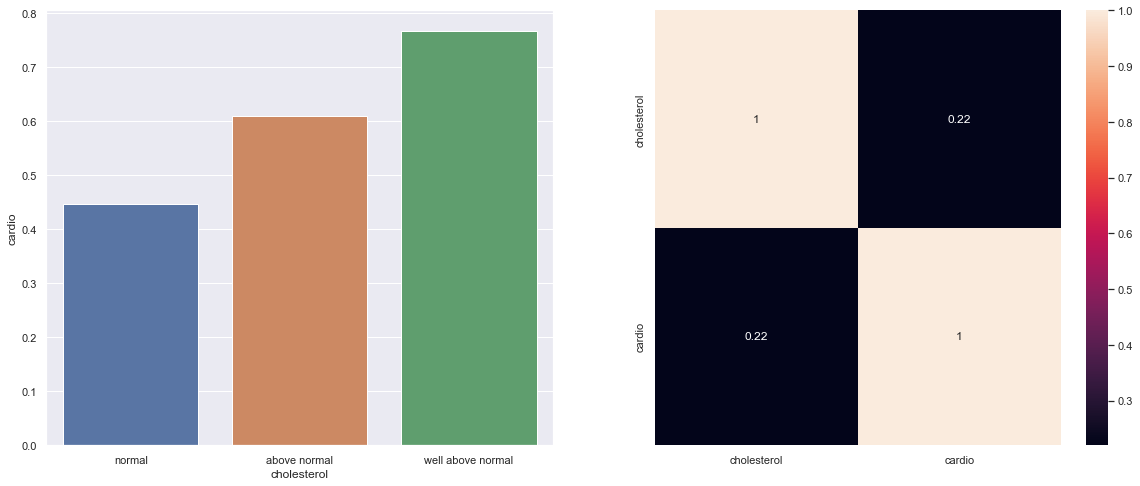

In [38]:
aux = df4[['cholesterol', 'cardio']].groupby('cholesterol').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(x='cholesterol', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(df4[['cholesterol', 'cardio']].corr(method='pearson'), annot=True)

7 - Quanto pior o quadro de diabetes, maior é a chance de ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

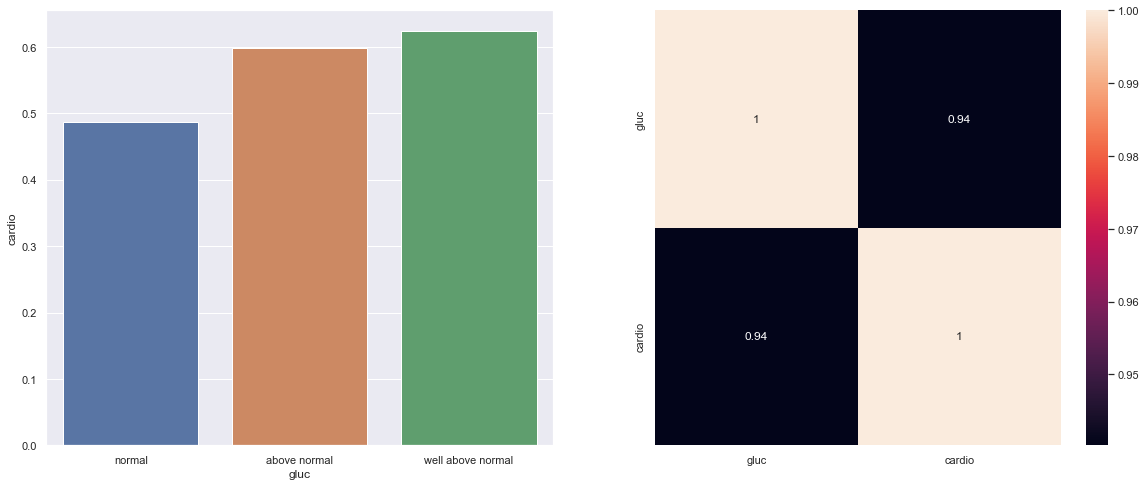

In [39]:
aux = df4[['gluc', 'cardio']].groupby('gluc').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gluc', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(aux.corr(method='pearson'), annot=True)

8 - Pessoas que fumam, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

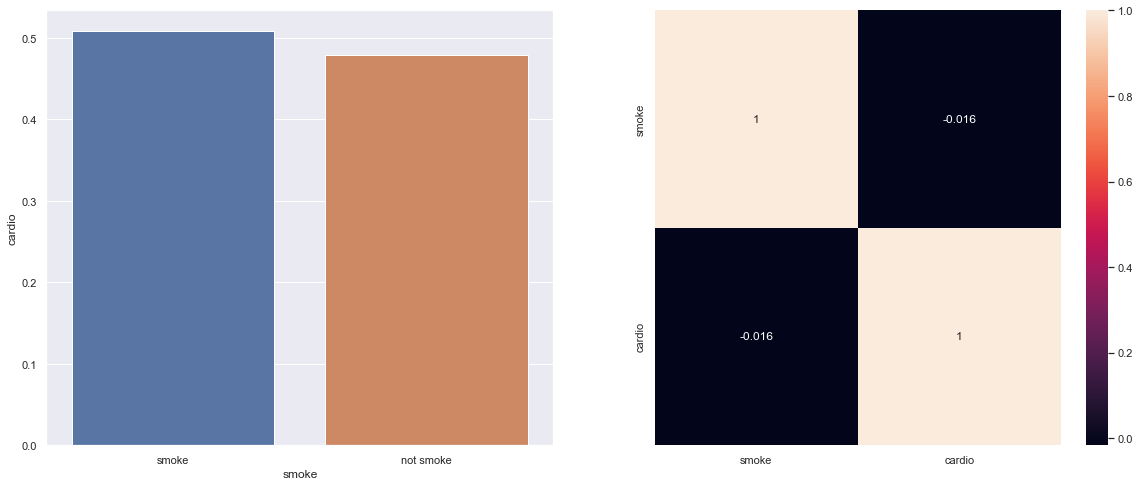

In [40]:
aux = df4[['smoke', 'cardio']].groupby('smoke').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='smoke', y='cardio', data=aux).set_xticklabels(['smoke', 'not smoke'])

plt.subplot(1,2,2)
sns.heatmap(df4[['smoke', 'cardio']].corr(method='pearson'), annot=True)

9 - Pessoas que alcool, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

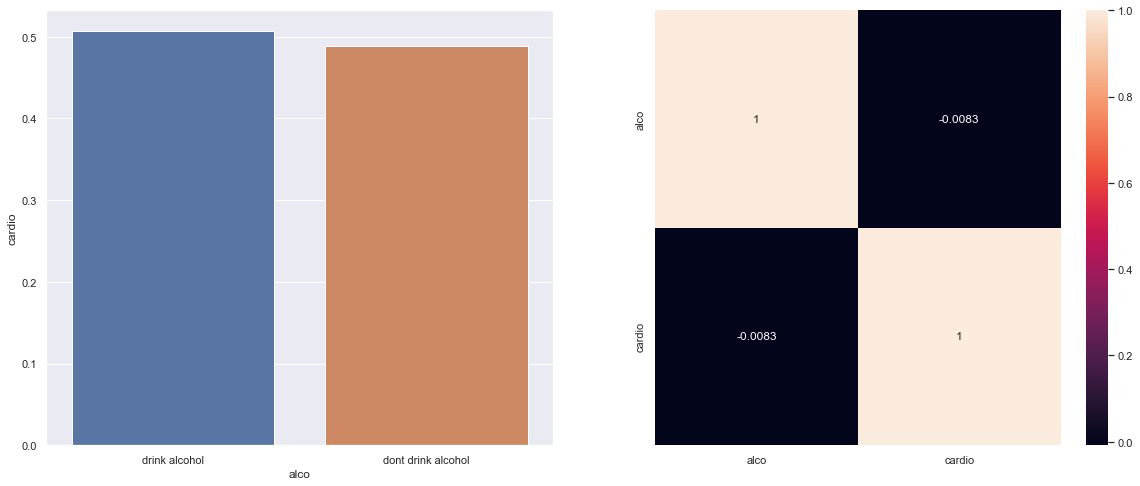

In [41]:
aux = df4[['alco', 'cardio']].groupby('alco').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='alco', y='cardio', data=aux).set_xticklabels(['drink alcohol', 'dont drink alcohol'])

plt.subplot(1,2,2)
sns.heatmap(df4[['alco', 'cardio']].corr(method='pearson'), annot=True)

10 - Pessoas que alcool, tem em média menor chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

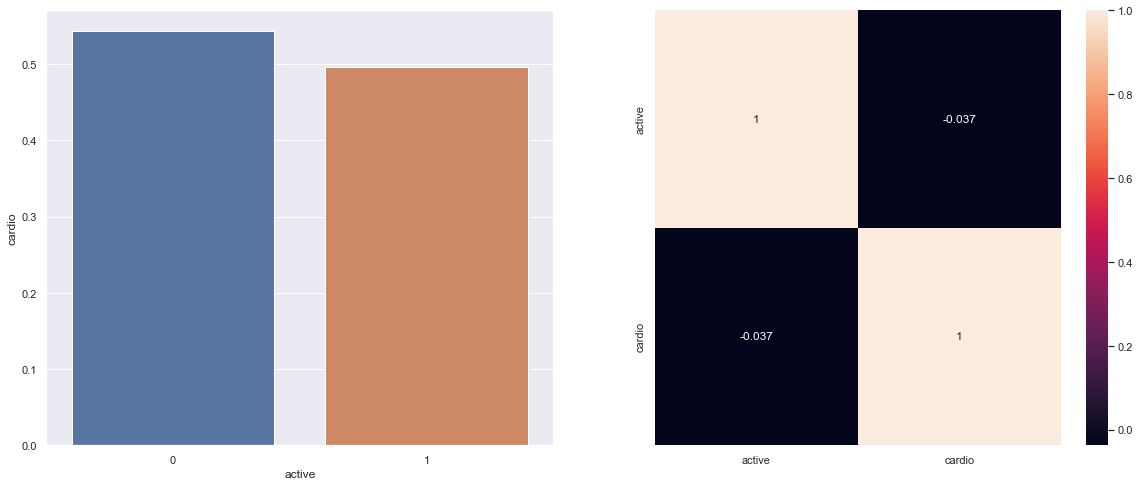

In [42]:
aux = df4[['active', 'cardio']].groupby('active').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='active', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df4[['active', 'cardio']].corr(method='pearson'), annot=True)

11 - Pessoas com imc maior, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

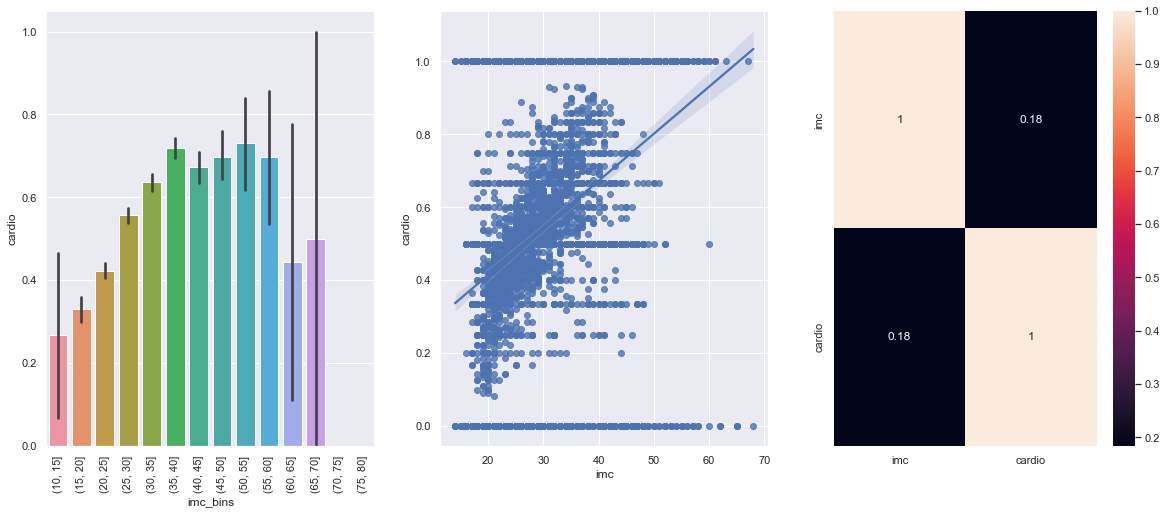

In [43]:
aux = df4[['imc', 'cardio']].groupby('imc').mean().reset_index()
aux['imc'] = np.int64(aux['imc'])

bins = list(np.arange(10,85, 5))

aux['imc_bins'] = pd.cut(aux['imc'], bins=bins)
aux1 = aux[['imc_bins', 'cardio']].groupby('imc_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='imc_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='imc', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['imc', 'cardio']].corr(method='pearson'), annot=True)

## 4.3 Análise Multivariada

### 4.5.1 Variáveis Numéricas

<AxesSubplot:>

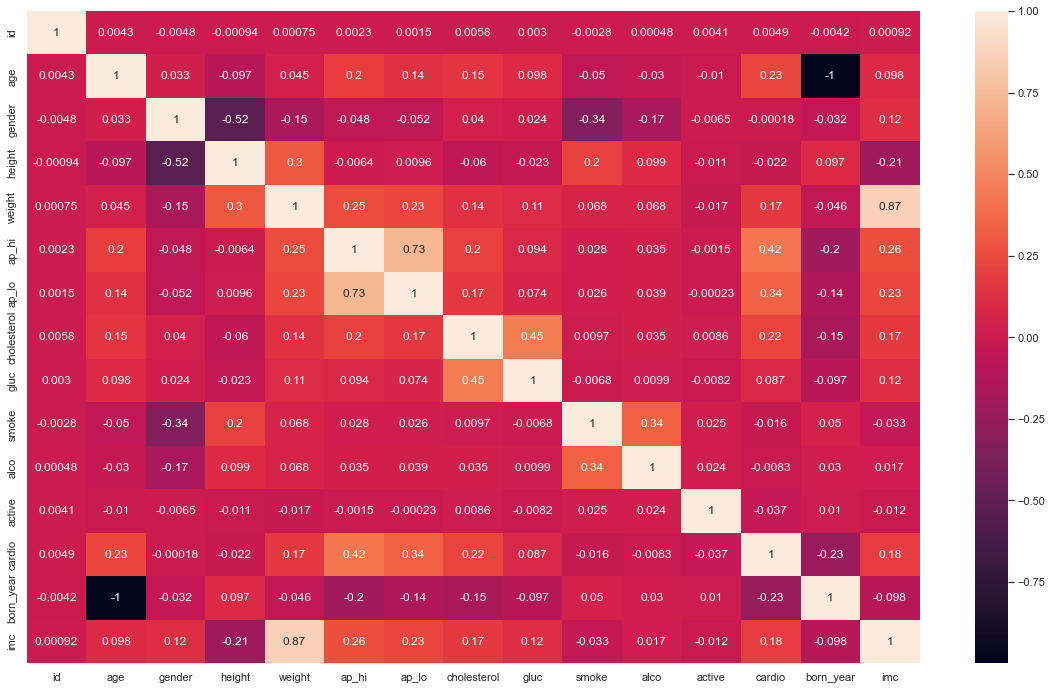

In [44]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20,12))
sns.heatmap(num_attributes.corr(method='pearson'), annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [45]:
df5 = df4.copy()

In [46]:
y = df5['cardio'].ravel()
X = df5.drop(['id', 'cardio'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## 5.1 Rescaling

In [47]:
X_train['age'] = rs.fit_transform(X_train[['age']].values)
X_test['age'] = rs.fit_transform(X_test[['age']].values)

X_train['idade'] = rs.fit_transform(X_train[['idade']].values)
X_test['idade'] = rs.fit_transform(X_test[['idade']].values)

X_train['born_year'] = rs.fit_transform(X_train[['born_year']].values)
X_test['born_year'] = rs.fit_transform(X_test[['born_year']].values)

X_train['height'] = rs.fit_transform(X_train[['height']].values)
X_test['height'] = rs.fit_transform(X_test[['height']].values)

X_train['weight'] = rs.fit_transform(X_train[['weight']].values)
X_test['weight'] = rs.fit_transform(X_test[['weight']].values)

X_train['ap_hi'] = rs.fit_transform(X_train[['ap_hi']].values)
X_test['ap_hi'] = rs.fit_transform(X_test[['ap_hi']].values)

X_train['ap_lo'] = rs.fit_transform(X_train[['ap_lo']].values)
X_test['ap_lo'] = rs.fit_transform(X_test[['ap_lo']].values)

X_train['imc'] = rs.fit_transform(X_train[['imc']].values)
X_test['imc'] = rs.fit_transform(X_test[['imc']].values)



## 5.2 Encoding

In [48]:
enc = MEstimateEncoder(cols=['gluc', 'cholesterol', 'blood_pressure'])
enc.fit(X_train, y_train)
X_train = enc.transform(X_train, y_train)
X_test = enc.transform(X_test, y_test)

X_train = pd.get_dummies(X_train, prefix=['smoke'],  columns=['smoke'])
X_test = pd.get_dummies(X_test, prefix=['smoke'],  columns=['smoke'])

X_train = pd.get_dummies(X_train, prefix=['alco'],  columns=['alco'])
X_test = pd.get_dummies(X_test, prefix=['alco'],  columns=['alco'])

X_train = pd.get_dummies(X_train, prefix=['active'],  columns=['active'])
X_test = pd.get_dummies(X_test, prefix=['active'],  columns=['active'])

In [49]:
c = SMOTETomek(sampling_strategy='auto', n_jobs=-1)
X_train, y_train = c.fit_resample(X_train, y_train)

# 6.0 SELEÇÃO DE FEATURES

In [50]:
df6 = df5.copy()

## 6.1 Separando DataFrame em treino e teste

In [51]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel()

#rf = RandomForestRegressor(n_jobs=-1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [52]:
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_not_selected_boruta = list(np.setdiff1d( X_train.columns, cols_selected_boruta))

In [53]:
#cols_selected_boruta

# 7.0 MACHINE LEARNING

## 7.1 Baseline Model

In [55]:
cardio = df5['cardio'].drop_duplicates().sort_values().tolist()
random_test = X_test.shape[0]
cardio_weights = df1['cardio'].value_counts(normalize=True).sort_index().tolist()


yhat_random = random.choices(cardio, k=X_test.shape[0],
                              weights=cardio_weights)


np.round(accuracy_score(yhat_random, y_test), 6)

AttributeError: module 'numpy.random' has no attribute 'choices'

### 7.1.1 Métricas Baseline Model

In [56]:
results = {'accuracy_score': accuracy_score(yhat_random, y_test),
            'precision_score': precision_score(yhat_random, y_test),
            'recall_score': recall_score(yhat_random, y_test),
            'f1_score': f1_score(yhat_random, y_test),
            'roc_auc': roc_auc_score(yhat_random, y_test),
            'kappa_score': cohen_kappa_score(yhat_random, y_test)}

b_result = pd.DataFrame(results, index=['Baseline Model'])*100
b_result

NameError: name 'yhat_random' is not defined

## 7.2 Logistic Regression

In [57]:
lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)
yh_lr = lr_model.predict(X_test)

lr_result = df_scores(model_name='LogisticRegression', y_test=y_test, y_pred=yh_lr, normalize=True)
lr_result

c:\Users\Roney\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
LogisticRegression,72.4,75.814,67.107,71.195,72.489,44.891


### 7.1.2 Logistic Regression CV

## 7.2 LGBM Classifier

In [ ]:
lgbm = LGBMClassifier(n_jobs=-1)
lgbm_model = lgbm.fit(X_train, y_train)
yh_lgbm = lgbm_model.predict(X_test)

lgbm_result = df_scores(model_name='LGBMClassifier', y_test=y_test, y_pred=yh_lgbm, normalize=True)
lgbm_result

,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
LGBMClassifier,73.071,75.708,69.758,72.612,73.151,46.215


### 7.2.1 LGBM Classifier CV

## 7.3 Ridge Classifier

In [ ]:
ridge = RidgeClassifier()
ridge_model = ridge.fit(X_train, y_train)
yh_ridge = ridge_model.predict(X_test)

ridge_result = df_scores(model_name='RidgeClassifier', y_test=y_test, y_pred=yh_ridge, normalize=True)
ridge_result

,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
RidgeClassifier,71.4,74.751,66.267,70.254,71.501,42.907


### 7.3.1 Ridge Classifier CV

## 7.4 XGBoost Classifier

In [ ]:
xgboost = xgb.XGBClassifier()
xgb_model = xgboost.fit(X_train, y_train)

yh_xgb = xgb_model.predict(X_test)

xgb_result = df_scores(model_name='XGBClassifier', y_test=y_test, y_pred=yh_xgb, normalize=False)
xgb_result

,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
XGBClassifier,0.727585,0.758655,0.684297,0.71956,0.728533,0.456087


In [ ]:
yh_xgb_cv = cross_val_predict(xgb_model, X_test, y_test)

xgb_result_cv = df_scores(model_name='XGBClassifier', y_test=y_test, y_pred=yh_xgb_cv, normalize=True)
xgb_result_cv

## 7.5 Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier()
gbc_model = gbc.fit(X_train, y_train)

yh_gbc = gbc.predict(X_test)

gbc_result = df_scores(model_name='GradientBoostingClassifier', y_test=y_test, y_pred=yh_gbc, normalize=True)
gbc_result

,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
GradientBoostingClassifier,72.911,75.652,69.082,72.218,72.986,45.894


### 7.5.1 Gradient Boosting Classifier CV

## 7.6 Bagging Classifier 

In [ ]:
bgg = BaggingClassifier()
bgg_model = bgg.fit(X_train, y_train)

yh_bgg = bgg.predict(X_test)

bgg_result = df_scores(model_name='BaggingClassifier', y_test=y_test, y_pred=yh_bgg, normalize=True)
bgg_result

### 7.6.1 Bagging Classifier CV

## 7.7 Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)

yh_rfc = rfc_model.predict(X_test)

rfc_result = df_scores(model_name='RandomForestClassifier', y_test=y_test, y_pred=yh_rfc, normalize=True)
rfc_result


,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
RandomForestClassifier,71.713,73.891,68.813,71.261,71.77,43.482


### 7.7.1 Random Forest Classifier CV

## 7.8 Métricas

In [ ]:
result = pd.DataFrame()
result = pd.concat([b_result, lr_result, lgbm_result, ridge_result, xgb_result, gbc_result, bgg_result, rfc_result])
result.sort_values('precision_score', ascending=False)

### 7.8.1 Métricas CV

# 8.0 HYPERPARAMETER FINE TUNING 

## 8.1 Definindo os hyper parametros para o FineTuning

### 8.1.1 Randomized Search (LGBM Classifier)

In [ ]:
parameters = {'max_depth': np.arange(2, 12, 2), 
              'num_leaves': 2 ** np.arange(2, 10, 2),
              'min_data_in_leaf': np.arange(650, 1050, 50), 
              'learning_rate': np.linspace(0.001, 0.6, 15),
              'colsample_bytree': np.linspace(0.1, 1, 5),
              'subsample': np.linspace(0.01, 1, 15),
              'n_estimators': np.arange(10, 105, 15)}

lgbm_random_cv = RandomizedSearchCV(estimator=lgbm, param_distributions=parameters,
                                scoring='precision', n_iter=100, cv=10, verbose=2, n_jobs=-1)

a = lgbm_random_cv.fit(X_train, y_train)
a.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


LGBMClassifier(colsample_bytree=0.1, learning_rate=0.34328571428571425,
               max_depth=2, min_data_in_leaf=950, n_estimators=40,
               num_leaves=64, subsample=0.4342857142857143)

In [ ]:
lgbm_tunned = LGBMClassifier(colsample_bytree=0.1, learning_rate=0.34328571428571425,
               max_depth=2, min_data_in_leaf=950, n_estimators=40,
               num_leaves=64, subsample=0.4342857142857143)

lgbm_model = lgbm_tunned.fit(X_train, y_train)
yh = lgbm_model.predict(X_test)

lgbm_model = df_scores(model_name='LGBMClassifier Tunned', y_test=y_test, y_pred=yh, normalize=True)
lgbm_model


[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
LGBMClassifier Tunned,72.644,76.799,66.687,71.386,72.787,45.43
